In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model, Sequential
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras.activations import softmax, sigmoid
from keras.objectives import binary_crossentropy as bce
from keras.layers import *
from keras.layers.core import *

import theano
import theano.tensor as T

np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

Using Theano backend.
Using gpu device 0: GeForce GTX 690 (CNMeM is disabled, cuDNN 5105)


In [3]:
s = K.variable(np.array([[0.9, 0.25], [0.33, 0.86]]))
print s.eval()

# turn sigmoid "probabilities" into class probabilities, then take the log
log_vec = K.log(s)


u = K.random_uniform(K.shape(log_vec), 0, 1)
gumbel_noise = -K.log(-K.log(u + 1e-20) + 1e-20)

temp = 0.2
probs = K.sigmoid((gumbel_noise + log_vec) / temp)

print probs.eval()


'''
w = np.zeros(s.shape.eval())
for i in xrange(0, 100):
    expected = T.dot(probs, discrete_values)
    w += expected.eval()
print w
'''


CudaNdarray([[0.900000 0.250000]
 [0.330000 0.860000]])
[[0.000334 0.457108]
 [0.215285 0.121852]]


'\nw = np.zeros(s.shape.eval())\nfor i in xrange(0, 100):\n    expected = T.dot(probs, discrete_values)\n    w += expected.eval()\nprint w\n'

In [103]:
def np_softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

discrete_values = np.array([0.0, 1.0])
#probs_y = np.array([[0.9, 0.25], [0.33, 0.86]])

# turn sigmoid "probabilities" into class probabilities, then take the log
#probs = np.reshape(probs_y, (probs_y.shape[0], probs_y.shape[1], 1))
#inv_probs = 1.0 - probs
#vec = np.concatenate([inv_probs, probs], axis = 2)
#log_vec = np.log(vec)

#log_vec = np.log([0.499, 0.501])

log_vec = np.array([-0.001, 0.002])

temps = [2.0, 1.5, 1.0, 0.5, 0.25, 0.1, 0.05]

print np_softmax(log_vec / 1.0)
print np_softmax(log_vec / 0.5)
print np_softmax(log_vec / 0.25)
print np_softmax(log_vec / 0.1)
print np_softmax(log_vec / 0.05)
print np_softmax(log_vec / 0.01)
print np_softmax(log_vec / 0.0025)
print np_softmax(log_vec / 0.001)
print np_softmax(log_vec / 0.0001)

'''
for curr_temp in temps:
    samples = []
    
    for i in xrange(0, 1000):
        u = np.random.uniform(0.0, 1.0, log_vec.shape)
        gumbel_noise = -np.log(-np.log(u + 1e-10) + 1e-10)
        final_probs = np_softmax((log_vec + gumbel_noise) / curr_temp)
        expected = np.dot(final_probs, discrete_values)
        
        samples.append(expected)
    
    binspace = np.linspace(0, 1, 21)
    
    plt.hist(samples, bins = binspace)
    plt.xlim([0, 1.01])
    plt.show()
'''

[0.499250 0.500750]
[0.498500 0.501500]
[0.497000 0.503000]
[0.492501 0.507499]
[0.485004 0.514996]
[0.425557 0.574443]
[0.231475 0.768525]
[0.047426 0.952574]
[0.000000 1.000000]


'\nfor curr_temp in temps:\n    samples = []\n    \n    for i in xrange(0, 1000):\n        u = np.random.uniform(0.0, 1.0, log_vec.shape)\n        gumbel_noise = -np.log(-np.log(u + 1e-10) + 1e-10)\n        final_probs = np_softmax((log_vec + gumbel_noise) / curr_temp)\n        expected = np.dot(final_probs, discrete_values)\n        \n        samples.append(expected)\n    \n    binspace = np.linspace(0, 1, 21)\n    \n    plt.hist(samples, bins = binspace)\n    plt.xlim([0, 1.01])\n    plt.show()\n'

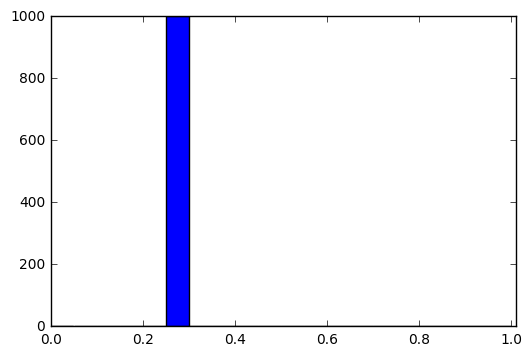

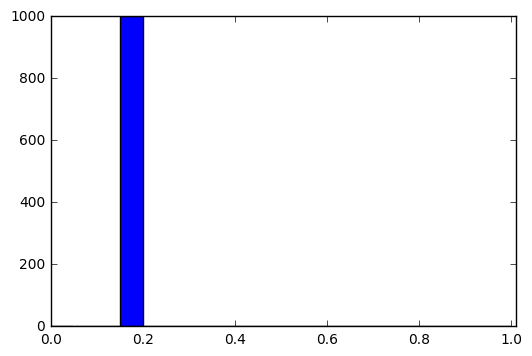

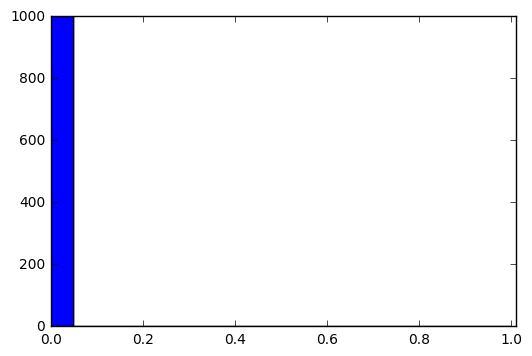

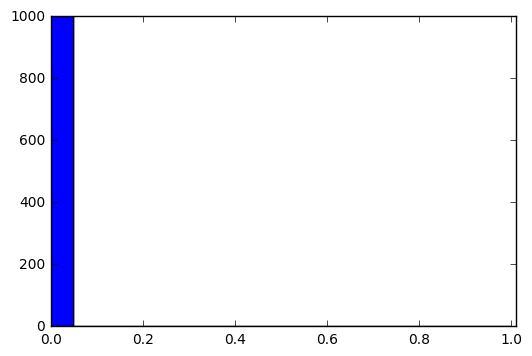

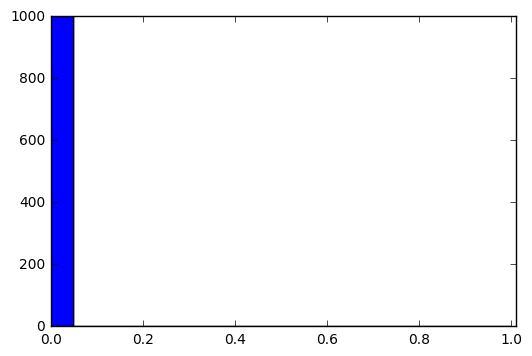

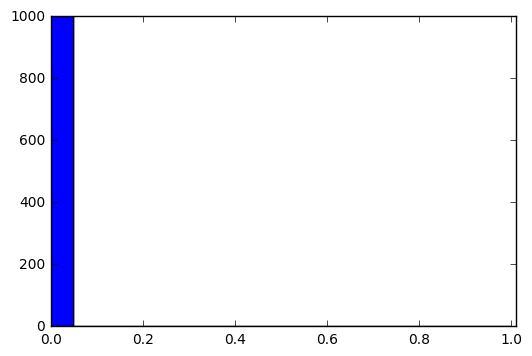

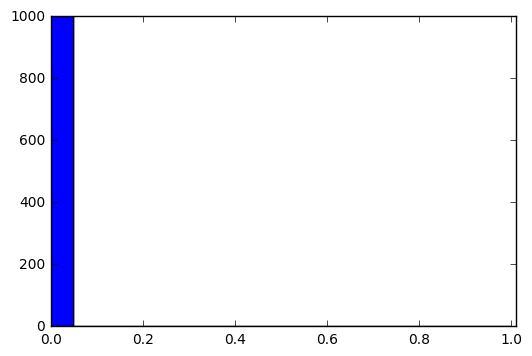

In [69]:
def sigmoid(x):
    return np.clip((x + 1.0) / 2.0, 0.0, 1.0)
    #return np.max(0, np.min(1, (x + 1)/2))
    #return 1 / (1 + np.exp(-x))

log_p = -1

temps = [2.0, 1.5, 1.0, 0.5, 0.25, 0.1, 0.05]

for curr_temp in temps:
    samples = []
    
    for i in xrange(0, 1000):
        u = random.uniform(0.0, 1.0)
        gumbel_noise = -np.log(-np.log(u + 1e-10) + 1e-10)
        prob = sigmoid((gumbel_noise + log_p) / curr_temp)
        
        samples.append(prob)
    
    binspace = np.linspace(0, 1, 21)
    
    plt.hist(samples, bins = binspace)
    plt.xlim([0, 1.01])
    plt.show()

In [206]:


batch_size = 128
data_dim = 784
N = 32
nb_epoch = 100
epsilon_std = 0.01

tau = K.variable(1.0, name="temperature")
anneal_rate = 0.01
min_temperature = 0.01

# encoder => code
x = Input(batch_shape=(batch_size, data_dim))
h = Dense(512, activation = 'linear')(x)
h = LeakyReLU(0.3)(h)
h = Dense(256, activation = 'linear')(x)
h = LeakyReLU(0.3)(h)
logits_y = Dense(N, activation = 'linear')(h)
#logits_y = Lambda(lambda x : 4.0 * K.tanh(x))(logits_y)

def sampling(logits_y):
    u = K.random_uniform(K.shape(logits_y), 0, 1)
    gumbel_noise = -K.log(-K.log(u + 1e-20) + 1e-20)

    probs = K.sigmoid((gumbel_noise + logits_y) / tau)
    return probs
    
    '''
    # turn sigmoid "probabilities" into class probabilities, then take the log
    probs = K.reshape(probs_y, (probs_y.shape[0], probs_y.shape[1], 1))
    inv_probs = 1.0 - probs
    vec = K.concatenate([inv_probs, probs], axis = 2)
    log_vec = K.log(vec)
    
    # gumbel noise
    u = K.random_uniform(K.shape(probs_y), 1e-5, 1)
    gumbel_noise = -K.log(-K.log(u + 1e-20) + 1e-20)
    
    # calculated probabilities and retrieve expected value
    final_probs = softmax((log_vec + gumbel_noise) / tau)
    expected = T.dot(final_probs, discrete_values)
    '''

    # final output is expected value
    #return probs

z = Lambda(sampling, output_shape=(N,))(logits_y)
generator = Sequential()
generator.add(Dense(256, input_shape=(N, )))
generator.add(LeakyReLU(0.3))
generator.add(Dense(512))
generator.add(LeakyReLU(0.3))
generator.add(Dense(data_dim, activation='sigmoid'))
x_hat = generator(z)

# x_hat = Dense(data_dim, activation='softmax')(Dense(512, activation='relu')(Dense(256, activation='relu')(z)))
'''
def gumbel_loss(x, x_hat):
    q_y = K.reshape(logits_y, (-1, N, M))
    q_y = softmax(q_y)
    log_q_y = K.log(q_y + 1e-20)
    kl_tmp = q_y * (log_q_y - K.log(1.0/M))
    KL = K.sum(kl_tmp, axis=(1, 2))
    elbo = data_dim * bce(x, x_hat) - KL 
    return elbo
'''

vae = Model(x, x_hat)
vae.compile(optimizer='adam', loss='mean_squared_error')
print "compiled"

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

for epoch in range(nb_epoch):
    vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=1,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        verbose = 1)
    K.set_value(tau, np.max([K.get_value(tau) * np.exp(- anneal_rate * epoch), min_temperature]))
    print K.get_value(tau)

compiled
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 2s - loss: 0.0506 - val_loss: 0.0346
1.0
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 2s - loss: 0.0296 - val_loss: 0.0256
0.99004983902
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 2s - loss: 0.0243 - val_loss: 0.0225
0.970445513725
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 2s - loss: 0.0221 - val_loss: 0.0209
0.94176453352
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 2s - loss: 0.0209 - val_loss: 0.0200
0.904837429523
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 2s - loss: 0.0201 - val_loss: 0.0195
0.860707998276
Train on 60000 samples, validate on 10000 samples


KeyboardInterrupt: 

# Visualize results

In [207]:
argmax_y = K.round(z)
encoder = K.function([x], [argmax_y, x_hat])

(<matplotlib.image.AxesImage at 0x7fe83a306cd0>, (-0.5, 27.5, 27.5, -0.5))

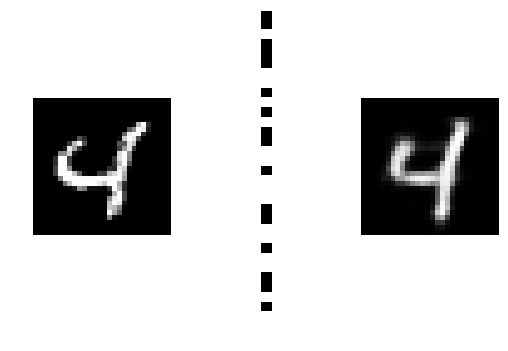

In [208]:
idx = 67

code, x_hat_test = encoder([x_test[idx:idx+1]])
subplot(131)
imshow(x_test[idx:idx+1].reshape(28, 28), cmap='gray', interpolation="nearest"), axis('off')
subplot(132)
imshow(code[:1].reshape(N,1), cmap='gray', interpolation="nearest"), axis('off')
subplot(133)
imshow(x_hat_test[:1].reshape(28, 28), cmap='gray', interpolation="nearest"), axis('off')

(<matplotlib.image.AxesImage at 0x7fe8287b20d0>, (-0.5, 27.5, 27.5, -0.5))

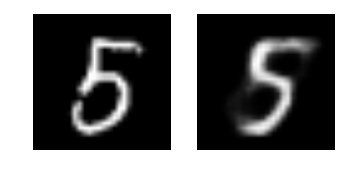

In [209]:
idx = 45
img = [x_test[idx:idx+1]]
x_hat_test = vae.predict(img)

subplot(131)
imshow(img[0].reshape(28, 28), cmap='gray'), axis('off')
subplot(132)
imshow(x_hat_test[0].reshape(28, 28), cmap='gray'), axis('off')

In [82]:
print code

print np.transpose(code, (0, 2, 1))

[[[1 0]
  [1 0]
  [0 1]
  [1 0]
  [1 0]
  [1 0]
  [0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]
  [1 0]
  [0 1]
  [1 0]
  [1 0]
  [1 0]
  [0 1]
  [1 0]
  [0 1]
  [0 1]
  [1 0]
  [1 0]
  [1 0]
  [0 1]
  [1 0]
  [1 0]
  [1 0]
  [0 1]
  [0 1]]]
[[[1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 1 0 0]
  [0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1]]]


(1, 32, 2)


(<matplotlib.image.AxesImage at 0x7f9c78863c10>, (-0.5, 27.5, 27.5, -0.5))

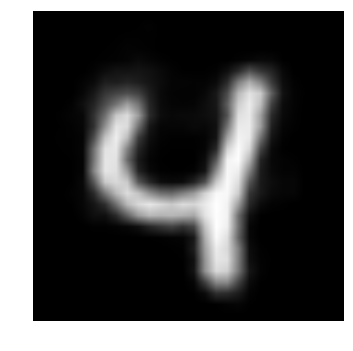

In [79]:
print code.shape
expected = T.dot(code, discrete_values)

img = generator(expected).eval()
imshow(img.reshape(28, 28), cmap='gray'), axis('off')

In [ ]:
C = np.zeros((6000, N*M))
for i in range(0, 6000, 100):
    c, _ = encoder([x_test[i:i+100]])
    C[i:i+100] = c.reshape(100, -1)

In [ ]:
from sklearn.manifold.t_sne import TSNE
tsne = TSNE(metric='hamming')
viz = tsne.fit_transform(C)

In [ ]:
from agnez import embedding2dplot
_ = embedding2dplot(viz, y_test[:6000], show_median=False)